A Survey on Technology Choice
======


In [252]:
library(dplyr)
library(tidyr)
library(caret)

In [253]:
library(randomForest)

In [254]:
# For nicer printing
options(digits=2);

In [255]:
# Read in the data
data <- read.csv("TechSurvey - Survey.csv",header=T);

#convert date to unix second
for (i in c("Start", "End")) 
    data[,i] = as.numeric(as.POSIXct(strptime(data[,i], "%Y-%m-%d %H:%M:%S")))
for (i in 0:12){
    vnam = paste(c("PG",i,"Submit"), collapse="")
    data[,vnam] = as.numeric(as.POSIXct(strptime(data[,vnam], "%Y-%m-%d %H:%M:%S")))
}
#calculate differences in time    
for (i in 12:0){
    pv = paste(c("PG",i-1,"Submit"), collapse="");
    if (i==0) 
        pv="Start";
    vnam = paste(c("PG",i,"Submit"), collapse="");
    data[,vnam] = data[,vnam] -data[,pv];
}

In [256]:
#now explore variables
summary(data);

     Device    Completed       Start               End               PG0Dis   
        :  2   0    :  2   Min.   :1.54e+09   Min.   :1.54e+09   Min.   :  0  
 Bot    :  1   FALSE:546   1st Qu.:1.54e+09   1st Qu.:1.54e+09   1st Qu.:  0  
 PC     :955   TRUE :805   Median :1.54e+09   Median :1.54e+09   Median :  1  
 Phone  :376               Mean   :1.54e+09   Mean   :1.54e+09   Mean   : 44  
 Tablet : 16               3rd Qu.:1.54e+09   3rd Qu.:1.54e+09   3rd Qu.: 24  
 Unknown:  3               Max.   :1.54e+09   Max.   :1.54e+09   Max.   :168  
                           NA's   :2          NA's   :548        NA's   :73   
    PG0Shown      PG0Submit    
 Min.   :   0   Min.   :    2  
 1st Qu.:   0   1st Qu.:    6  
 Median : 102   Median :    9  
 Mean   : 249   Mean   :  299  
 3rd Qu.: 428   3rd Qu.:   15  
 Max.   :1190   Max.   :76226  
 NA's   :73     NA's   :199    
                                       PG1PsnUse  
 For personal work and/or research use      :727  
          

### Interpret  basic summaries

In [257]:
#get numeric fields only for correlation
sel = c()
for (i in 1:dim(data)[2]) if (is.numeric(data[,i])) sel = c(sel, i);


cor(data[,sel],method="spearman",use="pairwise.complete.obs"); #OK for any: uses ranks

,Start,End,PG0Dis,PG0Shown,PG0Submit,PG1Submit,PG2Submit,PG3Submit,PG4Dtr0_6,PG4Psv7_8,...,PG5_12Order,PG5_13Order,PG5Submit,PG6Submit,PG7Submit,PG8Submit,PG9Submit,PG10Submit,PG11Submit,PG12Submit
Start,1.0000,0.9952,-0.0417,-0.11507,0.1350,0.1156,0.0791,0.0384,0.01210,0.00371,...,-0.0369,0.0598,0.08512,0.0054,0.0776,0.0441,0.04101,0.047,7.9e-02,0.0746
End,0.9952,1.0000,-0.0415,-0.09879,0.1142,0.1550,0.0791,0.0511,-0.05185,-0.04576,...,-0.0359,0.0661,0.09088,0.0051,0.0759,0.0435,0.04071,0.052,7.9e-02,0.0772
PG0Dis,-0.0417,-0.0415,1.0000,0.87220,0.0153,0.0065,0.0041,0.0567,0.16368,0.02668,...,0.0151,0.0384,0.00601,0.0277,0.0097,0.0354,0.00995,-0.029,-4.5e-02,0.0546
PG0Shown,-0.1151,-0.0988,0.8722,1.00000,0.0360,0.0205,0.0023,0.0497,0.08226,0.00036,...,0.0074,0.0407,-0.00888,0.0401,0.0121,0.0264,0.00056,-0.045,-7.1e-02,0.0436
PG0Submit,0.1350,0.1142,0.0153,0.03596,1.0000,0.1088,0.1037,0.1273,-0.00802,-0.03763,...,-0.0161,-0.0280,0.17671,0.1518,0.1365,0.1258,0.17579,0.225,1.1e-01,0.1096
PG1Submit,0.1156,0.1550,0.0065,0.02047,0.1088,1.0000,0.1452,0.2688,-0.06852,0.05661,...,0.0512,-0.0651,0.24670,0.2414,0.1133,0.1069,0.10895,0.170,7.4e-02,0.1137
PG2Submit,0.0791,0.0791,0.0041,0.00235,0.1037,0.1452,1.0000,0.2045,0.00146,0.00897,...,0.0210,-0.0047,0.21851,0.2696,0.1245,0.1567,0.20127,0.099,1.1e-01,0.1073
PG3Submit,0.0384,0.0511,0.0567,0.04968,0.1273,0.2688,0.2045,1.0000,0.00865,0.04424,...,0.0464,-0.0222,0.26048,0.2706,0.1316,0.1822,0.27450,0.161,1.4e-01,0.1642
PG4Dtr0_6,0.0121,-0.0518,0.1637,0.08226,-0.0080,-0.0685,0.0015,0.0087,1.00000,NA,...,0.1774,-0.1289,-0.05214,-0.1618,0.1560,0.0695,-0.07292,0.044,8.4e-04,-0.0272
PG4Psv7_8,0.0037,-0.0458,0.0267,0.00036,-0.0376,0.0566,0.0090,0.0442,NA,1.00000,...,-0.0008,-0.0218,0.08974,-0.0146,-0.0363,0.0526,0.05977,0.069,-4.9e-02,-0.0217


Interpret correlations: onlys start vs End, calculate difference instead


### Simple questions

- Time to take entire survey?
- Question that took the longest to complete?
- Question that took the least time?
- Top-ranked criteria?
- Demographic distribution by age?

In [258]:
data_complete = filter(data, Completed == TRUE)

# Number of rows removed
print(nrow(data))
print(nrow(data_complete))

[1] 1353
[1] 805


In [259]:
# Survey Time
survey_time = data_complete$End - data_complete$Start
print(paste0("Max Survey Time: ", max(survey_time), ' seconds'))
print(paste0("Min Survey Time: ", min(survey_time), ' seconds'))
print(paste0("Average Survey Time: ", round(mean(survey_time)), ' seconds'))
print(paste0("Median Survey Time: ", median(survey_time), ' seconds'))

[1] "Max Survey Time: 87551 seconds"
[1] "Min Survey Time: 51 seconds"
[1] "Average Survey Time: 680 seconds"
[1] "Median Survey Time: 225 seconds"


In [260]:
# Select only completion times and remove a couple na
completion_time = select(data_complete, contains('Submit')) %>%
    na.omit()
print(summary(completion_time))

   PG0Submit       PG1Submit      PG2Submit      PG3Submit      PG4Submit  
 Min.   :    2   Min.   :   1   Min.   :   1   Min.   :   1   Min.   :  1  
 1st Qu.:    6   1st Qu.:  11   1st Qu.:   9   1st Qu.:  16   1st Qu.:  6  
 Median :   10   Median :  16   Median :  13   Median :  24   Median :  7  
 Mean   :  242   Mean   :  42   Mean   :  31   Mean   :  42   Mean   :  9  
 3rd Qu.:   15   3rd Qu.:  31   3rd Qu.:  31   3rd Qu.:  41   3rd Qu.:  9  
 Max.   :66474   Max.   :6892   Max.   :1470   Max.   :4648   Max.   :332  
   PG5Submit      PG6Submit      PG7Submit     PG8Submit     PG9Submit    
 Min.   :   3   Min.   :   1   Min.   :  1   Min.   :  1   Min.   :    0  
 1st Qu.:  45   1st Qu.:   7   1st Qu.:  6   1st Qu.:  5   1st Qu.:    7  
 Median :  62   Median :   9   Median :  8   Median :  8   Median :   10  
 Mean   :  85   Mean   :  25   Mean   : 11   Mean   : 12   Mean   :   40  
 3rd Qu.:  84   3rd Qu.:  12   3rd Qu.: 11   3rd Qu.: 14   3rd Qu.:   14  
 Max.   :4130   Ma

In [261]:
avg_completion_time = colMeans(completion_time)
med_completion_time = apply(completion_time, 2, FUN = median)
print('Average Completion Time')
print(avg_completion_time)
print('Median Completion Time')
print(med_completion_time)

[1] "Average Completion Time"
 PG0Submit  PG1Submit  PG2Submit  PG3Submit  PG4Submit  PG5Submit  PG6Submit 
     241.5       42.4       31.4       42.5        9.1       85.2       24.5 
 PG7Submit  PG8Submit  PG9Submit PG10Submit PG11Submit PG12Submit 
      10.6       11.6       39.9       16.7        6.4        7.8 
[1] "Median Completion Time"
 PG0Submit  PG1Submit  PG2Submit  PG3Submit  PG4Submit  PG5Submit  PG6Submit 
        10         16         13         24          7         62          9 
 PG7Submit  PG8Submit  PG9Submit PG10Submit PG11Submit PG12Submit 
         8          8         10          7          4          5 


On average the first question took the longest time to complete but this could be because people let it sit on their computer after they opened the survey and completed it later. Looking at the median time may be more useful and in this case, the fifth question took the longest.

The question that took the least amount of time on average was the median value as wee. This question was the 11th.

In [262]:
# Select only completion times and remove a couple na
crit_responses = select(data_complete, starts_with('PG5'), -ends_with('Time'), -ends_with('Order'), -ends_with('Submit')) 
print(summary(crit_responses))


           PG5_1RRPQ             PG5_2BNUI              PG5_3HDS  
                :335                  :381                  :225  
 Essential      : 59   Essential      :  3   Essential      :103  
 High Priority  :102   High Priority  : 25   High Priority  :199  
 Low Priority   : 85   Low Priority   :120   Low Priority   : 68  
 Medium Priority:130   Medium Priority: 91   Medium Priority:161  
 Not a Priority : 94   Not a Priority :185   Not a Priority : 49  
            PG5_4VGP              PG5_5PHR             PG5_6SSYOP 
                :311                  :213                  :310  
 Essential      : 22   Essential      : 79   Essential      : 61  
 High Priority  :109   High Priority  :247   High Priority  :136  
 Low Priority   : 87   Low Priority   : 63   Low Priority   : 83  
 Medium Priority:162   Medium Priority:160   Medium Priority:109  
 Not a Priority :114   Not a Priority : 43   Not a Priority :106  
           PG5_7NDYP              PG5_8CP               PG5_9F

The top ranked criteria was computing performance with 228 essential categorizations and 195 high priority.

The next ranked was familiarity with related packages with 165 essential categorizations and 241 high priority.

    18 - 24     25 - 34     35 - 44     45 - 54     55 - 64 65 and over 
         34         338         258          89          36           8 


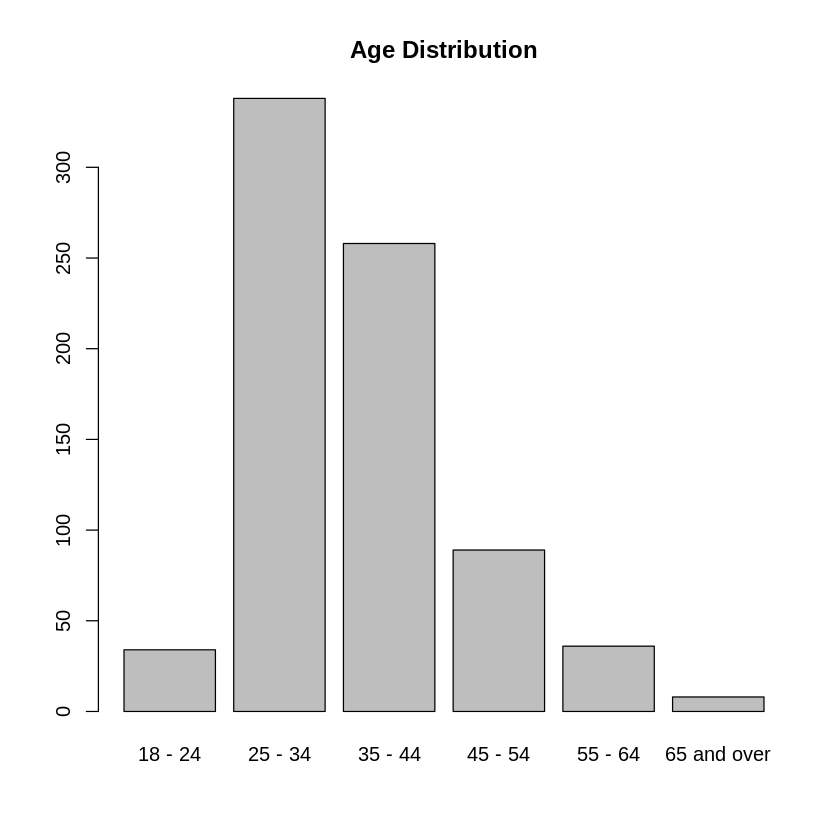

In [263]:
age = select(data_complete, PG12Resp) %>%
    filter(PG12Resp != '')

age1 = factor(age[,])

#barplot(prop.table(table(age$PG12Resp)))
print(summary(age1))
barplot(table(age1), main = 'Age Distribution')

### Modeling Resolves Problems Quickly Response Priority

In [116]:
colnames(data_complete)

[1] "Device"        "Completed"     "Start"         "End"          
 [5] "PG0Dis"        "PG0Shown"      "PG0Submit"     "PG1PsnUse"    
 [9] "PG1WdAuth"     "PG1Trn"        "PG1Other"      "PG1Submit"    
[13] "PG2Resp"       "PG2Submit"     "PG2Resp.1"     "PG3Submit"    
[17] "PG4Dtr0_6"     "PG4Psv7_8"     "PG4Prm9_10"    "PG4AllResp"   
[21] "PG4Submit"     "PG5_1RRPQ"     "PG5_1Order"    "PG5_1Time"    
[25] "PG5_2BNUI"     "PG5_2Order"    "PG5_2Time"     "PG5_3HDS"     
[29] "PG5_3Order"    "PG5_3Time"     "PG5_4VGP"      "PG5_4Order"   
[33] "PG5_4Time"     "PG5_5PHR"      "PG5_5Order"    "PG5_5Time"    
[37] "PG5_6SSYOP"    "PG5_6Order"    "PG5_6Time"     "PG5_7NDYP"    
[41] "PG5_7Order"    "PG5_7Time"     "PG5_8CP"       "PG5_8Order"   
[45] "PG5_8Time"     "PG5_9FRP"      "PG5_9Order"    "PG5_9Time"    
[49] "PG5_10RPA"     "PG5_10Order"   "PG5_10Time"    "PG5_11NSG"    
[53] "PG5_11Order"   "PG5_11Time"    "PG5_12NWG"     "PG5_12Order"  
[57] "PG5_12Time"    "PG5_13NFG"     "PG5_13Order"   "PG5_13Time"   
[61] "PG5Submit"     "PG6Resp"       "PG6Submit"     "PG7R"         
[65] "PG7C.C.."      "PG7Java"       "PG7Python"     "PG7Javascript"
[69] "PG7Go"         "PG7C."         "PG7Other"      "PG7Submit"    
[73] "PG8Resp"       "PG8Submit"     "PG9Resp"       "PG9Submit"    
[77] "PG10Resp"      "PG10Submit"    "PG11Resp"      "PG11Submit"   
[81] "PG12Resp"      "PG12Submit"

In [363]:
# Select vars for modeling
vars = c('Device' ,'Start','End','PG0Dis','PG0Shown','PG0Submit','PG1PsnUse','PG1Trn',
'PG1Submit' ,'PG2Resp','PG2Submit','PG2Resp.1' ,'PG3Submit' ,
'PG4AllResp','PG4Submit',
#'PG5_1RRPQ',
'PG5_1Order','PG5_1Time','PG5Submit','PG6Resp','PG6Submit','PG7R','PG7C.C..','PG7Java','PG7Python','PG7Javascript',
'PG7Go','PG7C.','PG7Other','PG7Submit','PG8Resp','PG8Submit','PG9Resp','PG9Submit','PG10Resp','PG10Submit',
'PG11Resp','PG11Submit','PG12Resp','PG12Submit')

vars1 = c('Device' ,'Start','End','PG0Dis','PG0Shown','PG0Submit','PG1PsnUse','PG1Trn',
'PG1Submit' ,'PG2Resp','PG2Submit','PG2Resp.1' ,'PG3Submit' ,
'PG4AllResp','PG4Submit',
'PG5_1RRPQ',
#'PG5_1Order',
'PG5_1Time','PG5Submit','PG6Resp','PG6Submit','PG7R','PG7C.C..','PG7Java','PG7Python','PG7Javascript',
'PG7Go','PG7C.','PG7Other','PG7Submit','PG8Resp','PG8Submit','PG9Resp','PG9Submit','PG10Resp','PG10Submit',
'PG11Resp','PG11Submit','PG12Resp','PG12Submit')

df = select(data_complete, vars) %>%
    drop_na(PG5_1Order) %>%
    na.omit()
print(summary(df))

df1 = select(data_complete, vars1) %>%
    drop_na(PG5_1RRPQ) %>%
    na.omit()
print(summary(df1))

     Device        Start               End               PG0Dis   
        :  0   Min.   :1.54e+09   Min.   :1.54e+09   Min.   :  0  
 Bot    :  0   1st Qu.:1.54e+09   1st Qu.:1.54e+09   1st Qu.:  0  
 PC     :323   Median :1.54e+09   Median :1.54e+09   Median :  1  
 Phone  : 88   Mean   :1.54e+09   Mean   :1.54e+09   Mean   : 45  
 Tablet :  5   3rd Qu.:1.54e+09   3rd Qu.:1.54e+09   3rd Qu.: 24  
 Unknown:  0   Max.   :1.54e+09   Max.   :1.54e+09   Max.   :168  
                                                                  
    PG0Shown      PG0Submit                                     PG1PsnUse  
 Min.   :   0   Min.   :    2   For personal work and/or research use:290  
 1st Qu.:   0   1st Qu.:    6                                        :120  
 Median : 118   Median :   10   Chapter book                         :  1  
 Mean   : 266   Mean   :   62   Learning how to create a package     :  1  
 3rd Qu.: 463   3rd Qu.:   16   Teaching                             :  1  
 Max.   

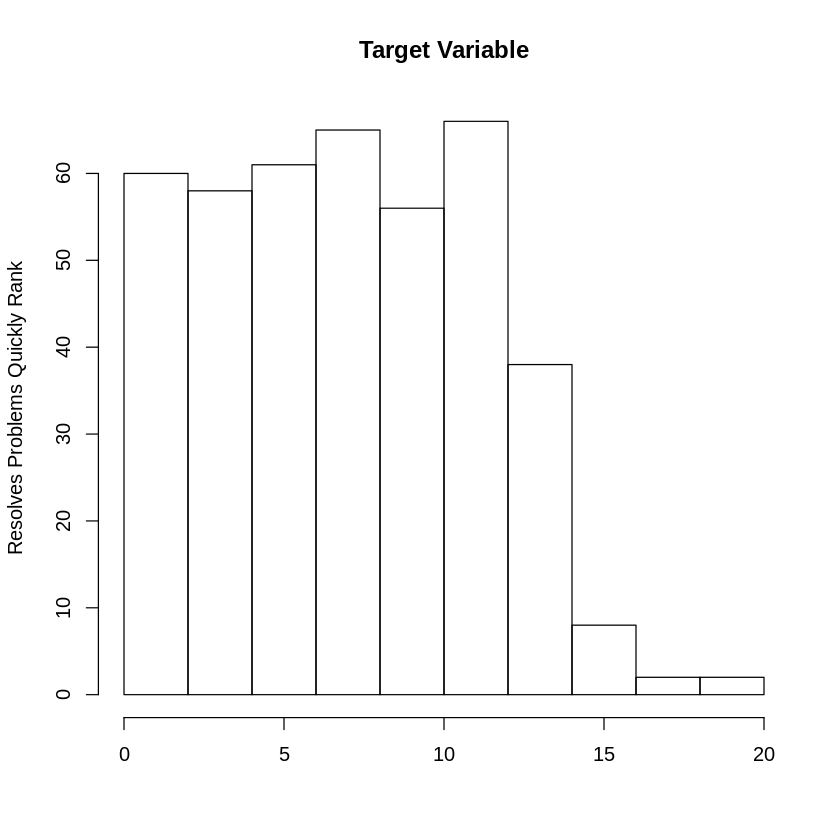

In [386]:
# look at distribution of target response
hist(df$PG5_1Order, main = "Target Variable", ylab = "Resolves Problems Quickly Rank", xlab = "")

In [378]:
# Removing level of target factor
df1 <- filter(df1, PG5_1RRPQ != '')
summary(df1$PG5_1RRPQ)
df1$PG5_1RRPQ <- factor(df1$PG5_1RRPQ)
summary(df1$PG5_1RRPQ)

Essential   High Priority    Low Priority Medium Priority 
              0              48              93              80             114 
 Not a Priority 
             81

Essential   High Priority    Low Priority Medium Priority  Not a Priority 
             48              93              80             114              81

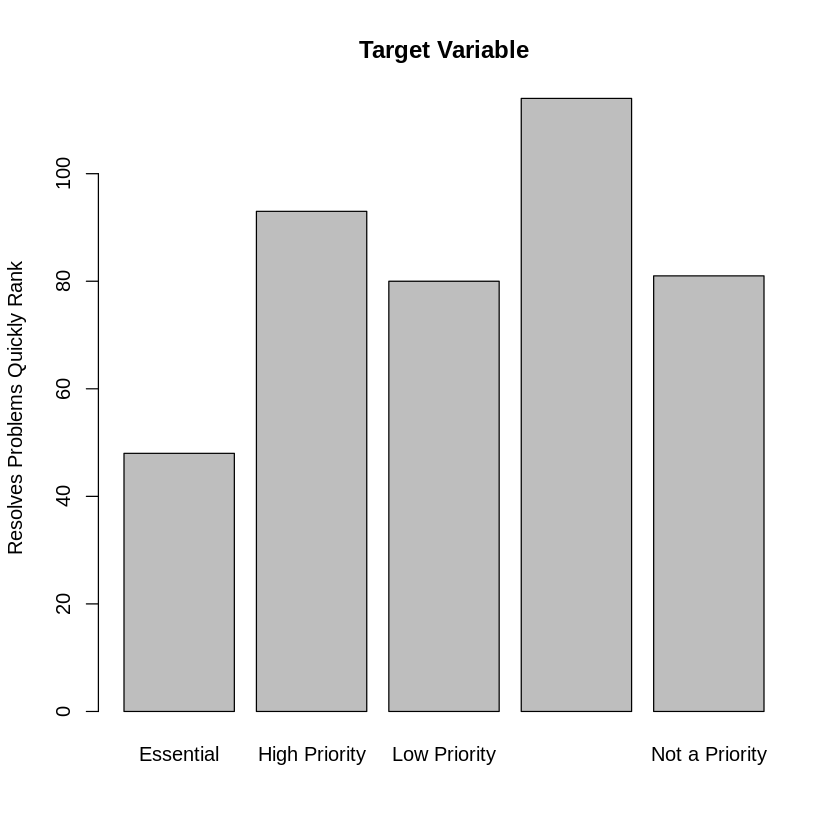

In [379]:
# look at distribution of target response
plot(df1$PG5_1RRPQ, main = "Target Variable", ylab = "Resolves Problems Quickly Rank")

In [321]:
# Checking type of vars
sapply(df, class)

# Checking na
print('DF!')
print(colSums(is.na(df)))
print('DF1!')
print(colSums(is.na(df1)))

Device         Start           End        PG0Dis      PG0Shown 
     "factor"     "numeric"     "numeric"     "integer"     "integer" 
    PG0Submit     PG1PsnUse        PG1Trn     PG1Submit       PG2Resp 
    "numeric"      "factor"      "factor"     "numeric"      "factor" 
    PG2Submit     PG2Resp.1     PG3Submit    PG4AllResp     PG4Submit 
    "numeric"      "factor"     "numeric"     "integer"     "numeric" 
   PG5_1Order     PG5_1Time     PG5Submit       PG6Resp     PG6Submit 
    "integer"      "factor"     "numeric"      "factor"     "numeric" 
         PG7R      PG7C.C..       PG7Java     PG7Python PG7Javascript 
     "factor"      "factor"      "factor"      "factor"      "factor" 
        PG7Go         PG7C.      PG7Other     PG7Submit       PG8Resp 
     "factor"      "factor"      "factor"     "numeric"      "factor" 
    PG8Submit       PG9Resp     PG9Submit      PG10Resp    PG10Submit 
    "numeric"      "factor"     "numeric"      "factor"     "numeric" 
     PG11Resp    PG11Submit      PG12Resp    PG12Submit 
     "factor"     "numeric"      "factor"     "numeric"

       Device         Start           End        PG0Dis      PG0Shown 
            0             0             0             0             0 
    PG0Submit     PG1PsnUse        PG1Trn     PG1Submit       PG2Resp 
            0             0             0             0             0 
    PG2Submit     PG2Resp.1     PG3Submit    PG4AllResp     PG4Submit 
            0             0             0             0             0 
   PG5_1Order     PG5_1Time     PG5Submit       PG6Resp     PG6Submit 
            0             0             0             0             0 
         PG7R      PG7C.C..       PG7Java     PG7Python PG7Javascript 
            0             0             0             0             0 
        PG7Go         PG7C.      PG7Other     PG7Submit       PG8Resp 
            0             0             0             0             0 
    PG8Submit       PG9Resp     PG9Submit      PG10Resp    PG10Submit 
            0             0             0             0             0 
     P

In [422]:
# Choose factor variables
df_fac = df[sapply(df, class) == 'factor']
# print(summary(df_fac))
# print(colnames(df_fac))
df1_fac = df1[sapply(df1, class) == 'factor']

In [268]:
# This was an attempt to convert matricies to dummy vars but not necessary for caret package (can handle factor vars)
df_fac_mm = data.frame(model.matrix(~ Device + PG1PsnUse + PG1Trn
              + PG2Resp + PG2Resp.1 + PG5_1Time + PG6Resp
             + PG7R + PG7C.C.. + PG7Java + PG7Python + PG7Javascript + PG7Go
             + PG7C. + PG7Other + PG8Resp + PG9Resp + PG10Resp + PG11Resp + PG12Resp, data=df_fac))

In [431]:
# Choose numeric and integer vars
df_num = log((df[sapply(df, class) == 'numeric'  | sapply(df, class) == 'integer']) + 1)
# print(summary(df_num))

In [432]:
# Recombine numeric and factor variables
df_final <- cbind(df_num, df_fac)
df_final1_c <- cbind(df_num, df1_fac)

### Regression

In [433]:
df_final1 = select(df_final, -c(PG5_1Time, PG2Resp.1, PG8Resp))

smp_size_r <- floor(0.75 * nrow(df_final1))

## set the seed to make your partition reproducible
set.seed(123)
train_ind_r <- sample(seq_len(nrow(df_final1)), size = smp_size_r)

training_r <- df_final[train_ind_r, ]
testing_r <- df_final[-train_ind_r, ]

In [434]:
fitControl <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 5,
                           ## repeated ten times
                           repeats = 2)

In [435]:
# The random forest package autmatically converts all factor variables and utilizes them  as dummy variables
set.seed(42)
rffitreg <- train(PG5_1Order ~ ., 
               data = training_r, 
               method = "rf", 
               importance = TRUE,
               trControl = fitControl)
rffitreg

Random Forest 

312 samples
 38 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 2 times) 
Summary of sample sizes: 249, 251, 250, 250, 248, 251, ... 
Resampling results across tuning parameters:

  mtry  RMSE  Rsquared  MAE 
    2   0.60  0.032     0.50
   44   0.59  0.059     0.48
  977   0.60  0.054     0.48

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 44.

In [436]:
preds = predict(rffitreg, testing_r)
error = mean(abs((testing_r$PG5_1Order-preds)))
print(mean(error))

[1] 0.43


In [437]:
varImp(rffitreg)

rf variable importance

  only 20 most important variables shown (out of 978)

                                                Overall
PG10Submit                                        100.0
PG9Resp2 - 3                                       66.4
PG5Submit                                          60.9
PG11Submit                                         54.0
PG2Submit                                          51.9
PG7PythonPython                                    51.3
PG12Submit                                         51.1
PG10RespNative                                     49.1
PG12Resp18 - 24                                    49.0
PG6Submit                                          47.2
PG2Resp.1I saw a recommendation for the package    45.3
PG9Submit                                          43.3
PG10RespNot native - full working proficiency      41.3
Start                                              39.5
PG0Submit                                          38.4
PG1Submit                

### Regression Results

The first effort was to rank the order of the responses to question 5. This was done using a regression. A regression is interesting in this case as because it was a ranking issue, the general structure of the responses can be derived from the data compared to classification where it is correct or incorrect. i.e. essential and high priority are similar and this is shown in predicting a value compared to a class.

A random forest was used and all numeric variables were used. Factor variables with more than 15 levels were eliminated from the dataset and remaining factor varaibles were converted to dummy variables. The log(x+1) of numeric values was taken to more evenly distrubute the data and prevent inf values. This transformation brought MAE from 3.4 to below 1. A small hyperparameter search was done using repeated cross validation with the only hyperparameter being number of variables tried at each split with this being 44.

The final MAE was about half a rank at 0.47.

The most important variable by a significant amount was PG10Submit which was english proficiency. This was followed by the dummy variable of how many software the user has been involved in. 

### Classification

In [443]:
df_final_class = select(df_final1_c, -c(PG5_1Time, PG2Resp.1, PG8Resp, PG5_1Order))

smp_size_c <- floor(0.75 * nrow(df_final_class))

## set the seed to make your partition reproducible
set.seed(123)
train_ind_c <- sample(seq_len(nrow(df_final_class)), size = smp_size_c)

training_c <- df_final_class[train_ind_c, ]
testing_c <- df_final_class[-train_ind_c, ]

In [444]:
fitControl <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 3,
                           ## repeated ten times
                           repeats = 2)

In [445]:
set.seed(42)
rffitclass <- train(PG5_1RRPQ ~ ., 
               data = training_c, 
               method = "rf", 
               importance = TRUE,
               trControl = fitControl,
                   verbose = TRUE)
rffitclass

Random Forest 

312 samples
 35 predictor
  5 classes: 'Essential', 'High Priority', 'Low Priority', 'Medium Priority', 'Not a Priority' 

No pre-processing
Resampling: Cross-Validated (3 fold, repeated 2 times) 
Summary of sample sizes: 209, 208, 207, 208, 208, 208, ... 
Resampling results across tuning parameters:

  mtry  Accuracy  Kappa  
    2   0.26      -0.0041
   61   0.27       0.0551
  120   0.27       0.0578

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 120.

In [446]:
preds = predict(rffitclass, testing_c)
conf = confusionMatrix(data = preds, reference = testing_c$PG5_1RRPQ)
conf

Confusion Matrix and Statistics

                 Reference
Prediction        Essential High Priority Low Priority Medium Priority
  Essential               0             2            2               2
  High Priority           1             7            4               3
  Low Priority            1             3            1               3
  Medium Priority         2             7           12              17
  Not a Priority          1             7            3               7
                 Reference
Prediction        Not a Priority
  Essential                    0
  High Priority                5
  Low Priority                 3
  Medium Priority             10
  Not a Priority               1

Overall Statistics
                                       
               Accuracy : 0.25         
                 95% CI : (0.17, 0.344)
    No Information Rate : 0.308        
    P-Value [Acc > NIR] : 0.919        
                                       
                  Kappa : 0.0

In [447]:
varImp(rffitclass)

rf variable importance

  variables are sorted by maximum importance across the classes
  only 20 most important variables shown (out of 120)

                                               Essential High Priority
PG1PsnUseFor personal work and/or research use     76.91         100.0
PG0Submit                                          31.69          77.5
PG6Submit                                          71.11          24.3
PG10RespNative                                     70.19          21.0
PG10Submit                                         68.03          27.0
PG6Resp2 - 5 years                                 32.24          21.2
PG7OtherOther                                      31.03          62.2
PG9Resp1                                            5.74          19.7
PG11RespFemale                                     46.61          16.9
Start                                              29.70          58.9
PG4AllResp                                         42.51          43.1
PG2Su

### Classification Results

The next effort was to classify the response based on the given categories. For this case, it is easy to misclassify as the model could be easily confused between essential and high priority for example. It would be interesting in future work to combine similar classes or use ordinal prediction.

A random forest was used again and all numeric variables were used. Factor variables with more than 15 levels were eliminated from the dataset and remaining factor varaibles were converted to dummy variables. The log(x+1) of numeric values was taken to more evenly distrubute the data and prevent inf values. This transformation brought MAE from 3.4 to below 1. A small hyperparameter search was done using repeated cross validation with the only hyperparameter being number of variables tried at each split with this being 120.

The final accuracy was about 25% but this may be improved by looking at amount of similar classes that were misclassified.

The variable importance is shown above as it relates to each class of the response variable. Interestintly, compared to regression, PG10Submit is less important for most classes where "PG1PsnUseFor personal work and/or research use" (A dummy variable) was more important for most classes.

### Survey Improvements

There could be several ways to improve the survey (as it relates to my target variable). 

The first improvement I would make is to eliminate the write in sections for the survey questions and add more options. This would make it easier for the user to take the survey. This would also prevent single variables from having tons of layers, making it less valuable for analysis (although you could do some more data cleaning and fix this issue).

Based on the variable importance, it would be nice if there were layers to some of the questions. For example, if you respond a certain way to a question like number of projects, it would also what type of projects which I think would give some clarity as to the type of person is taking the survey.

The "resovles problems quickly" variable may be more important to an IT person or someone of that type compared to a different job.

A timeout on the survey may help solve some of the time issues for people to answer and better clean out some of the people that opened the survey and completed it at a later time.